In [ ]:
!pip install pydicom

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# bSSFP Pulse Sequence Simulation

In [ ]:
import os
import numpy as np
import pydicom
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

def get_dicom_files_from_folder(folder_path):
    dicom_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.dcm')]
    return sorted(dicom_files)  # Sorting ensures correct slice order


def load_dicom_stack(dicom_files):
    slices = [pydicom.dcmread(file) for file in dicom_files]
    slices.sort(key=lambda x: float(x.ImagePositionPatient[2]) if hasattr(x, "ImagePositionPatient") else x.InstanceNumber)
    pixel_stack = np.stack([s.pixel_array.astype(np.float32) for s in slices])
    return pixel_stack

In [ ]:
def simulate_bSSFP(dicom_files_t1, dicom_files_t2, orientation='axial', sampling_mode='cartesian', num_spokes=250, sparsity=5, noise_std=0.05, flip_angle=25, TR=12, TE=3.15):
    """
    - orientation: str, 'sagittal', 'axial', or 'coronal' (default is 'axial').
    - sampling_mode: str, 'cartesian', 'radial_uni', or 'radial_var'.
    - num_spokes: int, number of spokes for radial sampling (used in radial modes).
    - density: int, density ratio for radial variable-density sampling.
    - noise_std: float, standard deviation of Gaussian noise added to k-space.
    - flip_angle: float, flip angle in degrees.
    - TR: float, Repetition Time in milliseconds.
    - TE: float, Echo Time in milliseconds.
    """

    t1_stack = load_dicom_stack(dicom_files_t1)
    t2_stack = load_dicom_stack(dicom_files_t2)
    t1_stack /= t1_stack.max()
    t2_stack /= t2_stack.max()

    if orientation == 'sagittal':
        t1_stack = np.transpose(t1_stack, (2, 1, 0))  # Swap axes for sagittal
        t2_stack = np.transpose(t2_stack, (2, 1, 0))

        t1_stack = np.rot90(t1_stack, k=1, axes=(1, 2))
        t2_stack = np.rot90(t2_stack, k=1, axes=(1, 2))

    elif orientation == 'coronal':
        t1_stack = np.transpose(t1_stack, (1, 0, 2))  # Swap axes for coronal
        t2_stack = np.transpose(t2_stack, (1, 0, 2))

        t1_stack = np.flipud(t1_stack)
        t2_stack = np.flipud(t2_stack)
        t1_stack = np.rot90(t1_stack, k=1, axes=(1, 2))  # Use k=1 for 90° CCW or k=3 for 90° CW
        t2_stack = np.rot90(t2_stack, k=1, axes=(1, 2))  # Use k=1 for 90° CCW or k=3 for 90° CW
        t1_stack = np.fliplr(t1_stack)
        t2_stack = np.fliplr(t2_stack)

    # middle slice
    t1_image = t1_stack[t1_stack.shape[0] // 2, :, :]
    t2_image = t2_stack[t2_stack.shape[0] // 2, :, :]

    # synthetic T1 and T2 maps
    T1_map = 200 + (1800 * t1_image)  # [200ms, 2000ms]
    T2_map = 20 + (230 * t2_image)   # [20ms, 250ms]
    M0_map = T1_map  # normalized intensity as M0 proxy

    plt.figure(figsize=(30, 15))

    # original images
    plt.subplot(2,4, 1)
    plt.title("T1-Weighted Image")
    plt.imshow(T1_map, cmap='gray')
    plt.colorbar()

    plt.subplot(2,4, 2)
    plt.title("T2-Weighted Image")
    plt.imshow(T2_map, cmap='gray')
    plt.colorbar()

    # calculate E1, E2, and simulate bSSFP signal
    E1_map = np.exp(-TR / T1_map)
    E2_map = np.exp(-TR / T2_map)
    alpha = np.radians(flip_angle)

    # TR = 3.15 ms

    # general Mss equation - from 'Principles and applications of balanced SSFP techniques'

    S_map1 = M0_map * np.sqrt(E2_map * (1 - E1_map)) * np.sin(alpha) / (1 - (E1_map - E2_map) * np.cos(alpha) - E1_map * E2_map)

    # Mss equation assuming that TR <<< T1,T2 - - from 'Principles and applications of balanced SSFP techniques'

    S_map2 = M0_map * (np.sin(alpha)) / (1 + np.cos(alpha) + (1 - np.cos(alpha)) * (T1_map / T2_map))


    # S_map = (M0_map * np.sin(alpha)) / (1 - E1_map + E2_map * (1 - np.cos(alpha))) --> old eqn and potentially incorrect

    plt.subplot(2,4, 3)
    plt.title("E1 Map")
    plt.imshow(E1_map, cmap='gray')
    plt.colorbar()

    plt.subplot(2,4, 4)
    plt.title("E2 Map")
    plt.imshow(E2_map, cmap='gray')
    plt.colorbar()

    plt.subplot(2,4, 5)
    plt.title("Steady-state Signal Map - without assumption TR<<<T1,T2")
    plt.imshow(S_map1, cmap='gray')
    plt.colorbar()

    plt.subplot(2,4, 6)
    plt.title("Steady-state Signal Map - with assumption TR<<<T1,T2")
    plt.imshow(S_map2, cmap='gray')
    plt.colorbar()

    plt.subplot(2,4, 7)
    plt.title("Difference without and with assumption TR<<<T1,T2")
    plt.imshow(np.abs(S_map1 - S_map2), cmap='viridis')
    plt.colorbar()

    Smap1 = S_map1

    S_map1 = S_map1.astype(np.complex128)
    S_map2 = S_map2.astype(np.complex128)

    # add off-resonance effects
    image_size = T1_map.shape
    df_map = np.random.uniform(-100, 100, image_size)  # Off-resonance frequency map (Hz)
    phi_map = 2 * np.pi * df_map * TR / 1000  # Convert TR to seconds
    S_map1 *= np.exp(1j * phi_map)

    # Cartesian k-space
    cartesian_kspace = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(S_map1)))

    # entire k-space before sampling
    plt.subplot(2,4, 8)
    plt.title("Cartesian k-Space (Pre-Sampling)")
    plt.imshow(np.log(1 + np.abs(cartesian_kspace)), cmap='gray')  # Log scale for better visualization
    plt.colorbar()

    plt.tight_layout()
    plt.show()


    plt.figure(figsize=(15, 10))

    plt.subplot(2, 3, 1)
    plt.title("Off-Resonance Frequency Map (df_map) [Hz]")
    plt.imshow(df_map, cmap='hsv')
    plt.colorbar(label='Frequency (Hz)')
    plt.xlabel('Pixels')
    plt.ylabel('Pixels')

    # Visualization of phase accumulation
    plt.subplot(2, 3, 2)
    plt.title("Off-Resonance Phase Map (phi_map) [radians]")
    plt.imshow(phi_map, cmap='hsv')
    plt.colorbar(label='Phase (radians)')
    plt.xlabel('Pixels')
    plt.ylabel('Pixels')

    # Visualization of magnitude of signal with off-resonance
    S_magnitude = np.abs(S_map1)
    plt.subplot(2, 3, 3)
    plt.title("Signal Magnitude with Off-Resonance")
    plt.imshow(S_magnitude, cmap='gray')
    plt.colorbar(label='Signal Magnitude')
    plt.xlabel('Pixels')
    plt.ylabel('Pixels')

    # Visualization of Cartesian k-space (pre-sampling) with off-resonance
    plt.subplot(2, 3, 4)
    plt.title("Cartesian k-Space with Off-Resonance (Log Scale)")
    plt.imshow(np.log(1 + np.abs(cartesian_kspace)), cmap='gray')
    plt.colorbar(label='Log Magnitude')
    plt.xlabel('k_x')
    plt.ylabel('k_y')

    plt.tight_layout()
    plt.show()


    # # radial sampling
    # if sampling_mode in ['radial_uni', 'radial_var']:

    #     golden_angle = np.pi * (3 - np.sqrt(5))  # golden angle for uniform coverage = 111.25 degres --> radians
    #     kx, ky = [], []
    #     samples_per_spoke = image_size[0] // 2

    #     # radial sampling points
    #     for i in range(num_spokes):
    #         angle = i * golden_angle
    #         if sampling_mode == 'radial_uni':
    #             radii = np.linspace(0, 1, samples_per_spoke)
    #         elif sampling_mode == 'radial_var':
    #             radii = np.linspace(0, 1, samples_per_spoke) ** sparsity  # Dense at center, sparse at the periphery
    #         for r in radii:
    #             kx.append(r * np.cos(angle))
    #             ky.append(r * np.sin(angle))

    #     kx, ky = np.array(kx), np.array(ky)

    #     # normalized Cartesian grid coordinates
    #     kx_cart, ky_cart = np.meshgrid(
    #         np.linspace(-1, 1, image_size[0]),
    #         np.linspace(-1, 1, image_size[1])
    #     )
    #     kx_cart = kx_cart.flatten()
    #     ky_cart = ky_cart.flatten()

    #     # Cartesian k-space data --> radial points
    #     radial_kspace = griddata(
    #         (kx_cart, ky_cart),
    #         cartesian_kspace.flatten(),
    #         (kx, ky),
    #         method='linear',
    #         fill_value=0
    #     )

    #     # noise to radial k-space
    #     noise = (np.random.normal(0, noise_std, radial_kspace.shape) +
    #              1j * np.random.normal(0, noise_std, radial_kspace.shape))
    #     radial_kspace_noisy = radial_kspace + noise

    #     # radial data --> Cartesian grid (regridding)
    #     cartesian_kspace_rg = griddata(
    #         (kx, ky),
    #         radial_kspace_noisy,
    #         (kx_cart, ky_cart),
    #         method='linear',
    #         fill_value=0
    #     ).reshape(image_size)

    #     # noise to Cartesian k-space
    #     noise = (np.random.normal(0, noise_std, cartesian_kspace_rg.shape) +
    #              1j * np.random.normal(0, noise_std, cartesian_kspace_rg.shape))
    #     cartesian_kspace_noisy = cartesian_kspace_rg + noise

    #     # radial sampling mechanism
    #     plt.subplot(2,4, 7)
    #     plt.title("Radial Sampling Pattern")
    #     plt.scatter(kx, ky, s=1, color='red', label='Sample Points')  # Sample points in k-space
    #     plt.xlabel("kx")
    #     plt.ylabel("ky")
    #     plt.legend()
    #     plt.axis('equal')
    #     plt.grid()

    #     # entire k-space after sampling
    #     plt.subplot(2,4, 8)
    #     plt.title("Radial k-Space (Post-Sampling)")
    #     plt.imshow(np.log(1 + np.abs(cartesian_kspace_noisy)), cmap='gray')  # Log scale for better visualization
    #     plt.colorbar()

    #     # radial k-space components (real, imaginary, magnitude)
    #     plt.subplot(2,4, 9)
    #     plt.title("Real Part of Radial k-Space")
    #     plt.imshow(np.real(cartesian_kspace_noisy),cmap='gray')
    #     plt.colorbar()

    #     plt.subplot(2,4, 10)
    #     plt.title("Imaginary Part of Radial k-Space)")
    #     plt.imshow(np.imag(cartesian_kspace_noisy), cmap='gray')
    #     plt.colorbar()

    #     plt.subplot(2,4, 11)
    #     plt.title("Magnitude of Radial k-Space")
    #     plt.imshow(np.abs(cartesian_kspace_noisy), cmap='gray')
    #     plt.colorbar()

    #     # reconstruct the image
    #     reconstructed_image = np.abs(np.fft.ifftshift(np.fft.ifft2(cartesian_kspace_noisy)))

    #     # reconstructed image
    #     plt.subplot(2,4, 12)
    #     plt.title("Reconstructed Image")
    #     plt.imshow(reconstructed_image, cmap='gray')
    #     plt.colorbar()

    #     plt.tight_layout()
    #     plt.show()

    # else: #default condition if 'cartesian'
    #     # add noise to Cartesian k-space
    #     noise = (np.random.normal(0, noise_std, cartesian_kspace.shape) +
    #              1j * np.random.normal(0, noise_std, cartesian_kspace.shape))
    #     cartesian_kspace_noisy = cartesian_kspace + noise

    #     # reconstruct the image
    #     reconstructed_image = np.abs(np.fft.ifftshift(np.fft.ifft2(cartesian_kspace_noisy)))

    return Smap1, T1_map, T2_map #reconstructed_image

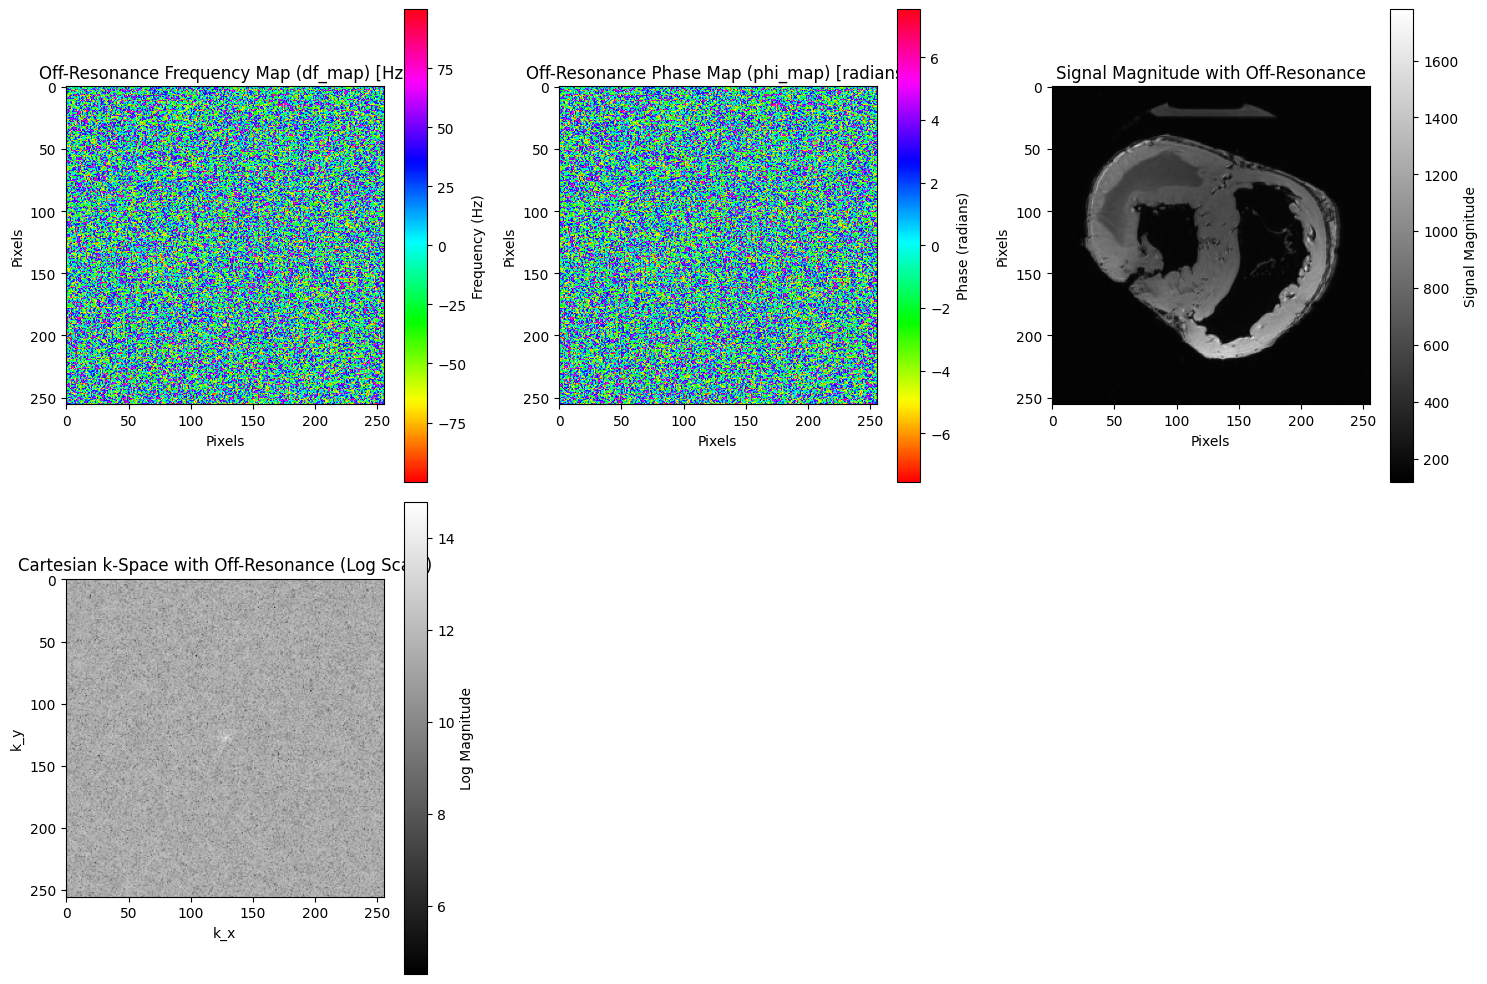

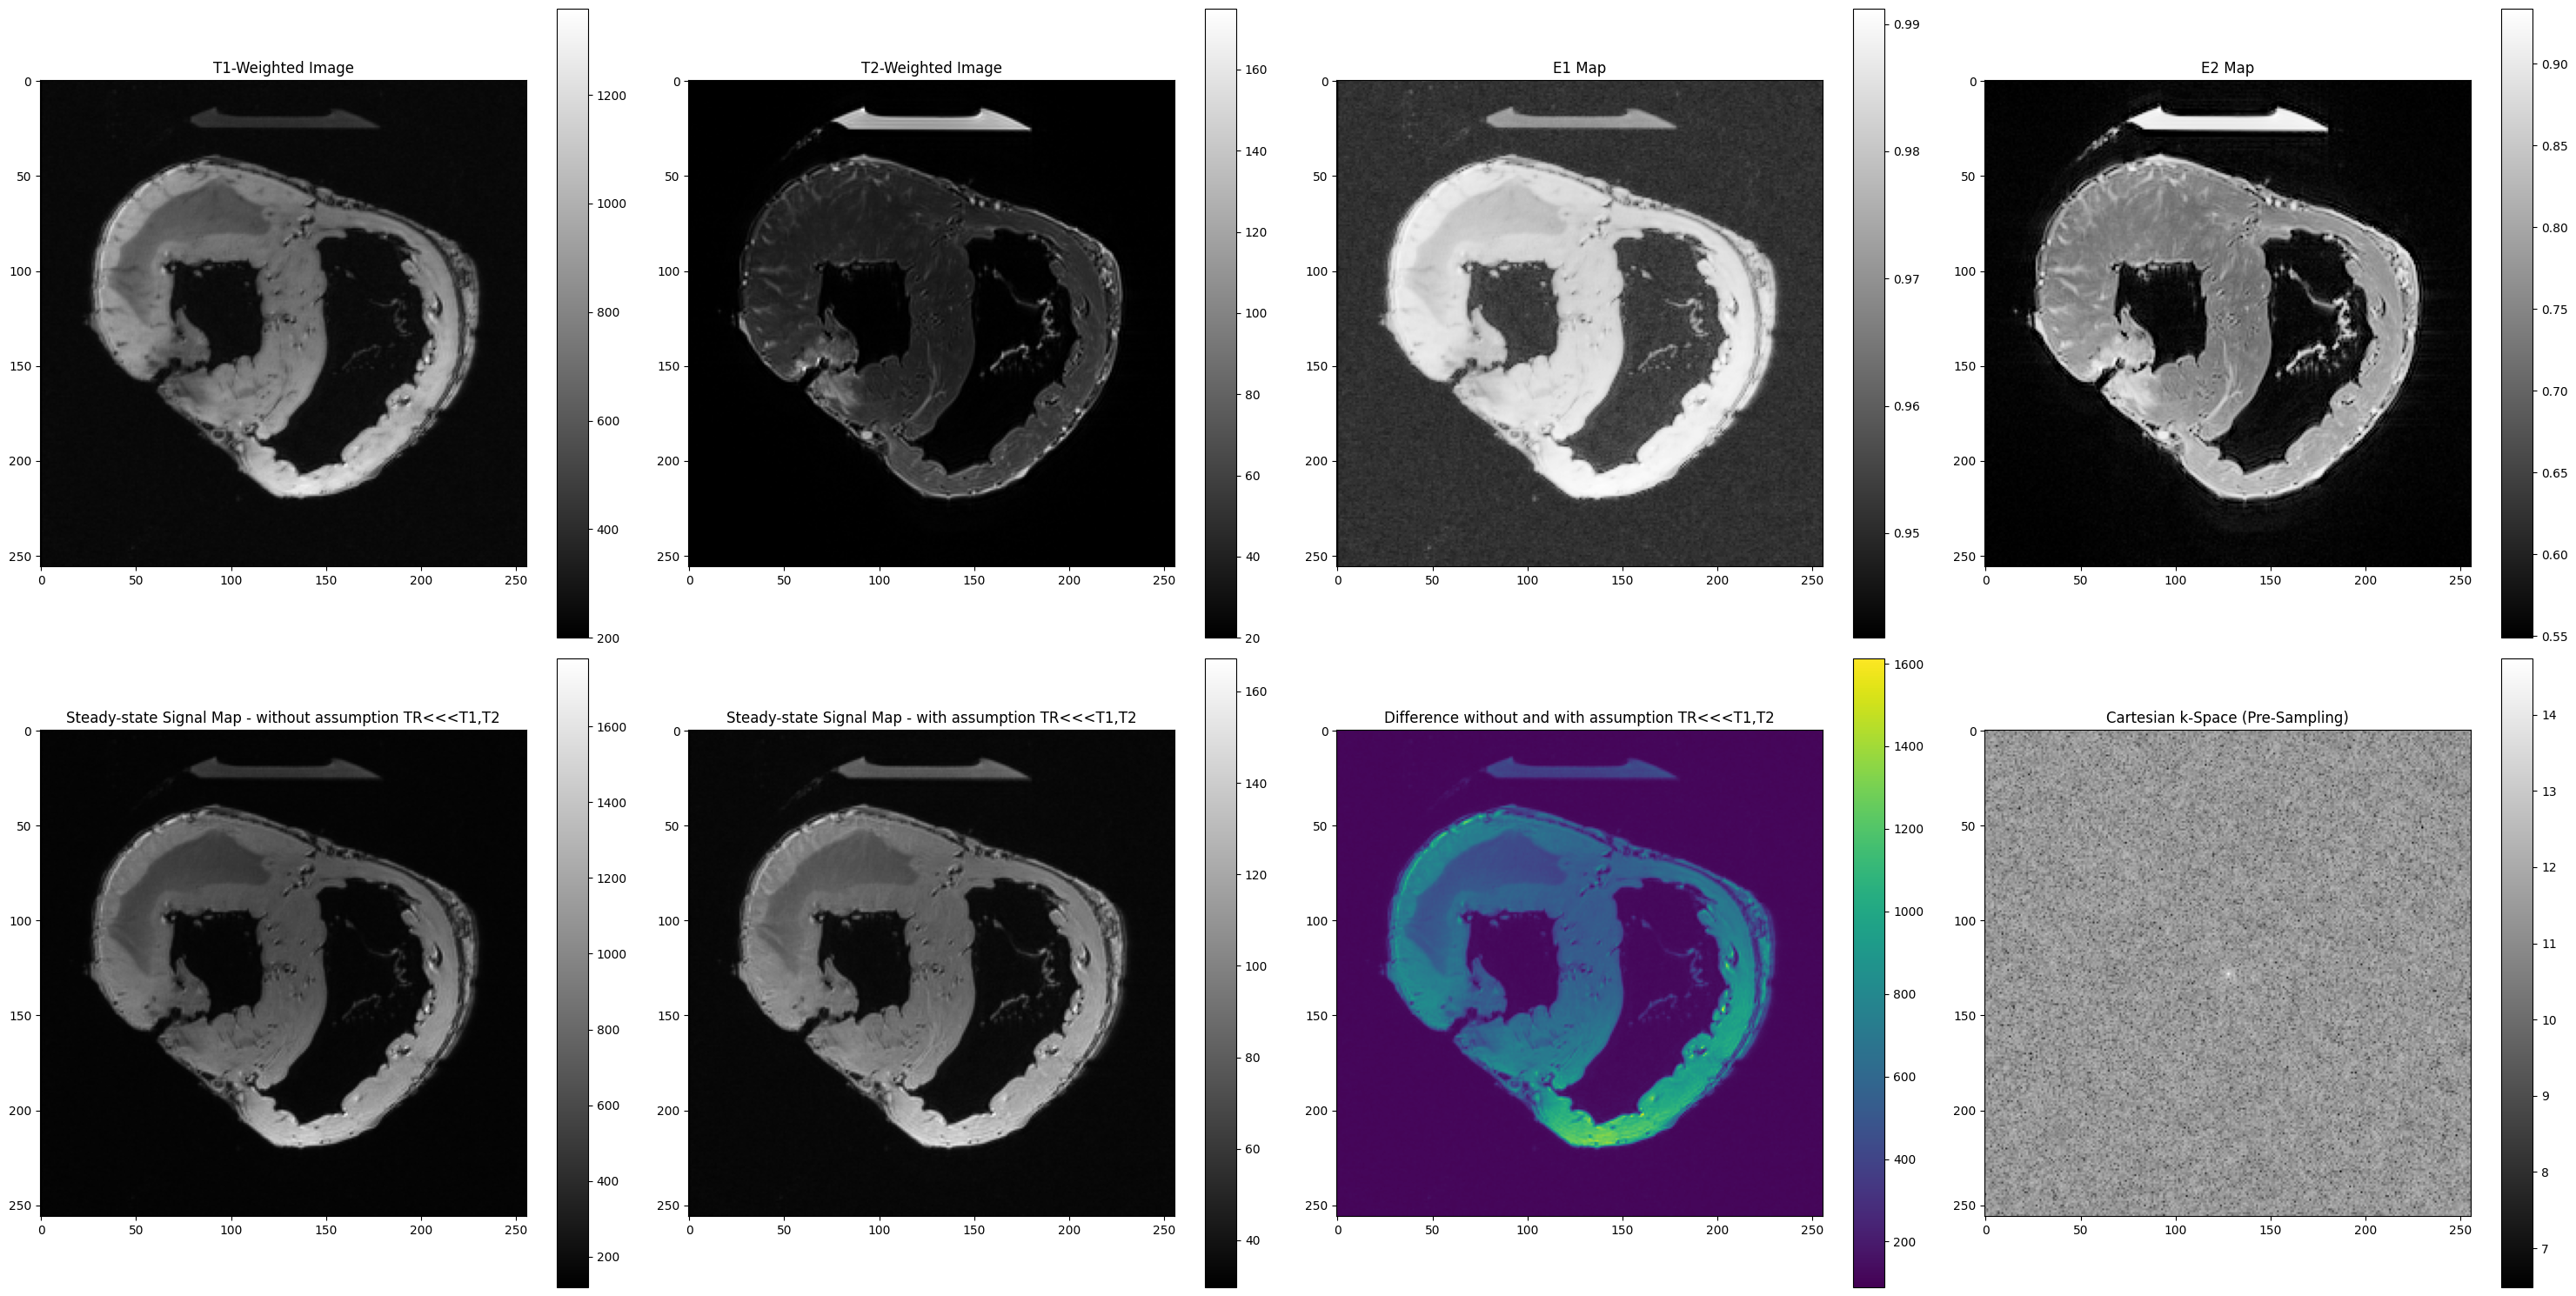

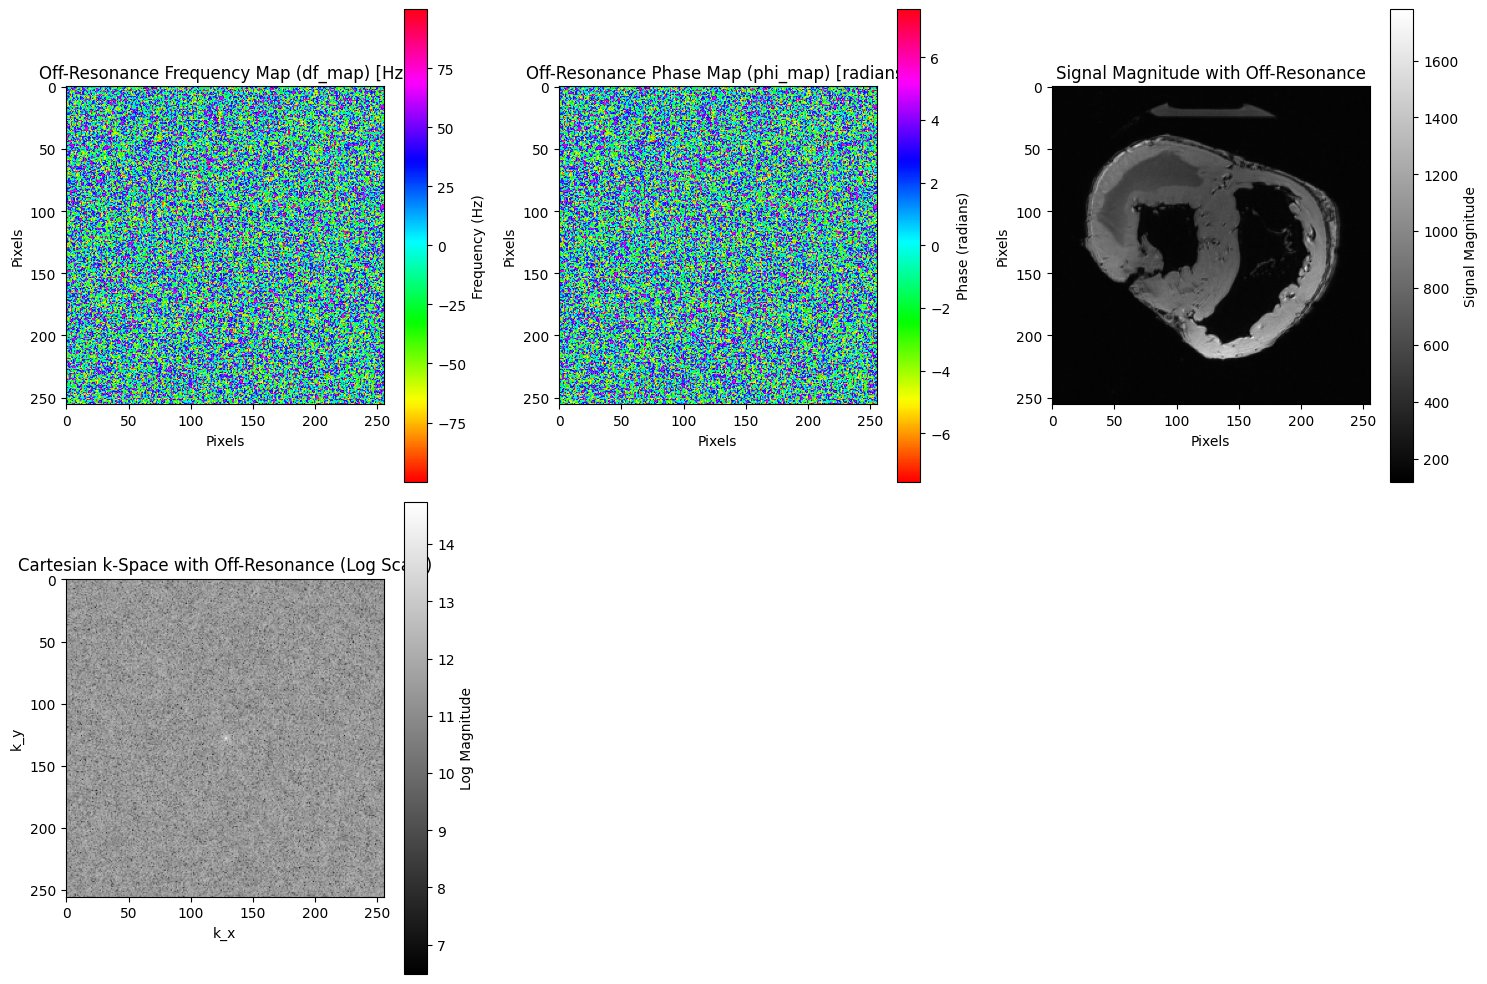

In [ ]:
t1_folder = "/content/drive/MyDrive/T1_Weighted/FLASH_3D_stitched"
t2_folder = "/content/drive/MyDrive/T2_Weighted/TSE_3D_stitched"

dicom_files_t1 = get_dicom_files_from_folder(t1_folder)
dicom_files_t2 = get_dicom_files_from_folder(t2_folder)

reconstructed_image_axial, _, _ = simulate_bSSFP(dicom_files_t1, dicom_files_t2, sampling_mode='radial_uni', orientation='axial')
s,t1,t2 = simulate_bSSFP(dicom_files_t1, dicom_files_t2, sampling_mode='radial_var', orientation='axial')

# Stack of stars

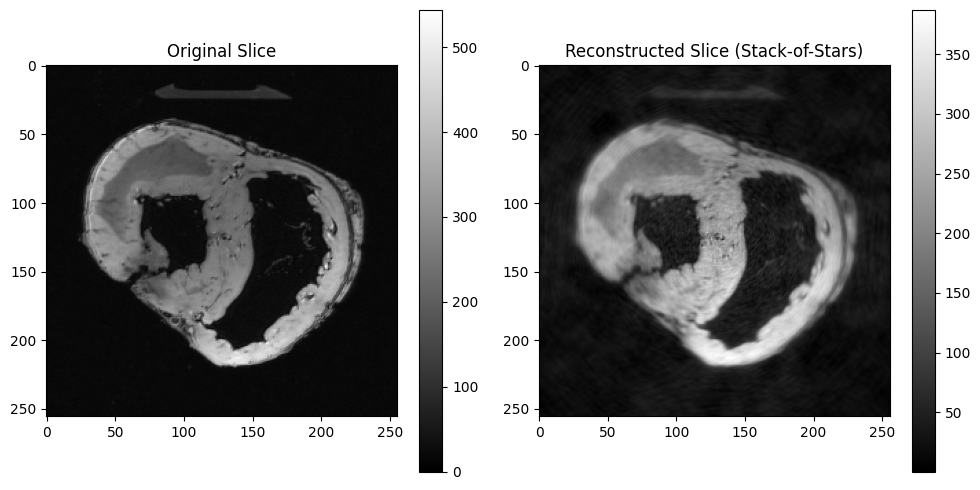

In [ ]:
def apply_stack_of_stars(dicom_stack, num_spokes=400, density=1, noise_std=0.01): #402 is optimal
    slices, height, width = dicom_stack.shape
    reconstructed_stack = np.zeros_like(dicom_stack, dtype=np.float32)

    # Define Cartesian grid
    kx_cart, ky_cart = np.meshgrid(
        np.linspace(-1, 1, height),
        np.linspace(-1, 1, width)
    )
    kx_cart = kx_cart.flatten()
    ky_cart = ky_cart.flatten()

    # Iterate over slices
    for z in range(slices):
        # Perform 2D Fourier transform to get k-space
        image = dicom_stack[z, :, :]
        cartesian_kspace = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(image)))

        # Create radial sampling pattern
        kx, ky = [], []
        golden_angle = np.pi * (3 - np.sqrt(5))  # Golden angle for uniform radial coverage
        radii = np.linspace(0, 1, height // 2) ** density  # Adjust density

        for i in range(num_spokes):
            angle = i * golden_angle
            for r in radii:
                kx.append(r * np.cos(angle))
                ky.append(r * np.sin(angle))

        kx = np.array(kx)
        ky = np.array(ky)

        # Interpolate Cartesian k-space data to radial points
        radial_kspace = griddata(
            (kx_cart, ky_cart),
            cartesian_kspace.flatten(),
            (kx, ky),
            method='linear',
            fill_value=0
        )

        # Add Gaussian noise
        radial_kspace_noisy = radial_kspace + noise_std * (
            np.random.normal(size=radial_kspace.shape) +
            1j * np.random.normal(size=radial_kspace.shape)
        )

        # Re-grid radial data back to Cartesian grid
        cartesian_kspace_rg = griddata(
            (kx, ky),
            radial_kspace_noisy,
            (kx_cart, ky_cart),
            method='linear',
            fill_value=0
        ).reshape((height, width))

        # Reconstruct the image from re-gridded k-space
        reconstructed_image = np.abs(np.fft.ifftshift(np.fft.ifft2(cartesian_kspace_rg)))
        reconstructed_stack[z, :, :] = reconstructed_image

    return reconstructed_stack


t1_folder = "/content/drive/MyDrive/T1_Weighted/FLASH_3D_stitched"
t2_folder = "/content/drive/MyDrive/T2_Weighted/TSE_3D_stitched"

dicom_files = get_dicom_files_from_folder(t1_folder)
dicom_stack = load_dicom_stack(dicom_files)

# Apply Stack-of-Stars sampling
reconstructed_stack = apply_stack_of_stars(dicom_stack, num_spokes=128, density=1.5)

# Visualize one slice
slice_index = dicom_stack.shape[0] // 2
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Slice")
plt.imshow(dicom_stack[slice_index, :, :], cmap='gray')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Reconstructed Slice (Stack-of-Stars)")
plt.imshow(reconstructed_stack[slice_index, :, :], cmap='gray')
plt.colorbar()

plt.tight_layout()
plt.show()

# Code draft for blood vessel detection - not tested

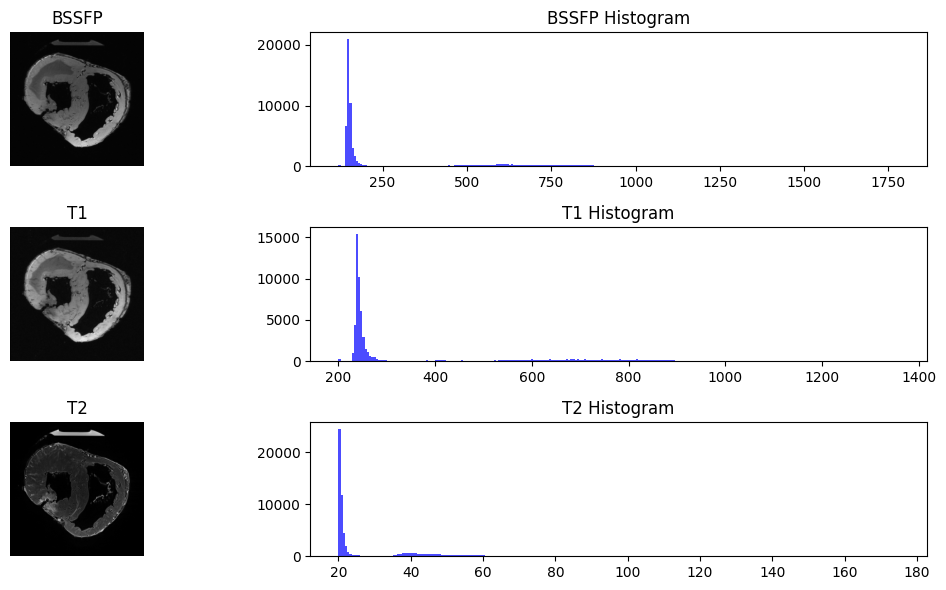

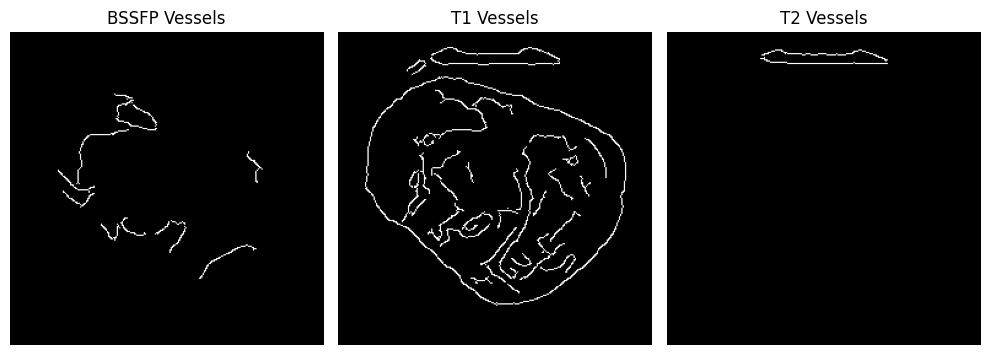

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def load_and_preprocess(image_path1, image_path2, image_path3, target_size=(256, 256)):
    # img1 = cv2.imread(image_path1, cv2.IMREAD_GRAYSCALE)
    # img2 = cv2.imread(image_path2, cv2.IMREAD_GRAYSCALE)
    # img3 = cv2.imread(image_path3, cv2.IMREAD_GRAYSCALE)

    img1 = cv2.resize(image_path1, target_size)
    img2 = cv2.resize(image_path2, target_size)
    img3 = cv2.resize(image_path3, target_size)

    return img1, img2, img3

def visualize_contrast(img1, img2,img3, titles=("BSSFP", "T1", "T2")):
    plt.figure(figsize=(12, 6))
    for i, img in enumerate([img1, img2, img3]):
        plt.subplot(3, 2, i * 2 + 1)
        plt.imshow(img, cmap='gray')
        plt.title(titles[i])
        plt.axis('off')
        plt.subplot(3, 2, i * 2 + 2)
        plt.hist(img.ravel(), bins=256, color='blue', alpha=0.7)
        plt.title(f'{titles[i]} Histogram')
    plt.tight_layout()
    plt.show()

def extract_vessels(img):
    # Ensure the image is in [0, 255] range and uint8 type
    if img.dtype != np.uint8:
        img = (img * 255).astype(np.uint8) if img.max() <= 1.0 else img.astype(np.uint8)

    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(img, (15,15), 0)

    # Apply Canny edge detection
    edges = cv2.Canny(blurred, 50, 150)
    return edges

def compare_extraction(img1_edges, img2_edges, img3_edges, titles=("BSSFP Vessels", "T1 Vessels", "T2 Vessels")):
    """Visualize edge-detected (vessel-extracted) images."""
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(img1_edges, cmap='gray')
    plt.title(titles[0])
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(img2_edges, cmap='gray')
    plt.title(titles[1])
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(img3_edges, cmap='gray')
    plt.title(titles[2])
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Paths to your images
image_path1 = s  # bSSFP image path
image_path2 = t1  #t1 mapping
image_path3 = t2  #t2 mapping

# Process and analyze
img1, img2, img3 = load_and_preprocess(image_path1, image_path2, image_path3)
visualize_contrast(img1, img2, img3)

# Extract blood vessels
img1_edges = extract_vessels(img1)
img2_edges = extract_vessels(img2)
img3_edges = extract_vessels(img3)

compare_extraction(img1_edges, img2_edges, img3_edges)


# misc - will incorporate as needed

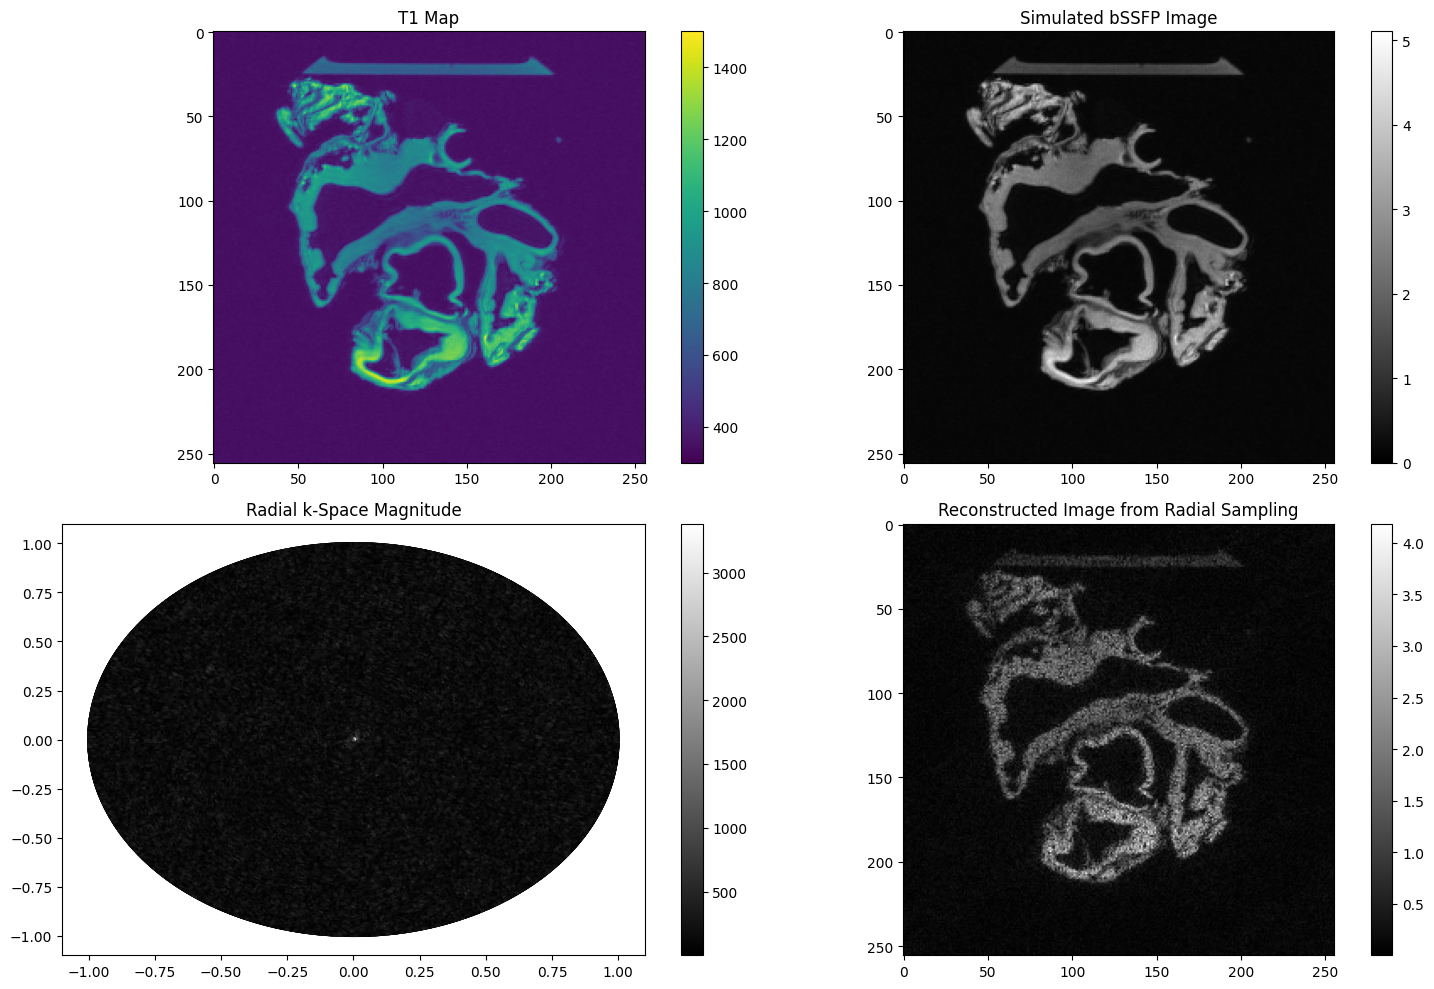

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import pydicom


# # Parameters for simulation
# image_size = (128, 128)  # Resolution
# TR = 5  # ms
alpha = np.radians(25)  # Flip angle in radians
num_spokes = 1000  # Number of radial spokes #5000 works great
golden_angle = np.pi * (3 - np.sqrt(5))  # Golden angle for uniform coverage

# # Generate tissue property maps
# T1_map = np.random.uniform(500, 1500, image_size)  # ms
# T2_map = np.random.uniform(50, 200, image_size)   # ms
# M0_map = np.ones(image_size)  # Uniform magnetization


# Load DICOM T1-weighted image
dicom_file = "/content/00215_t1.dcm"  # Replace with your DICOM file path
dicom_data = pydicom.dcmread(dicom_file)

# Extract pixel data
t1_weighted_image = dicom_data.pixel_array.astype(np.float32)

# Normalize the image (assuming 12-bit data; adjust based on your file)
t1_weighted_image /= t1_weighted_image.max()

# Generate a synthetic T1 map (approximation based on tissue types)
T1_map = 300 + (1200 * t1_weighted_image)  # Scale to range [300ms, 1500ms]

# Generate synthetic M0 map (use normalized intensity as proxy)
M0_map = t1_weighted_image

# Simulation parameters
image_size = T1_map.shape
T2_map = np.random.uniform(50, 100, image_size)  # Example T2 values (adjust if needed)
TR = 12  # ms
TE = 3.15  # Define Echo Time as half of TR
df_map = np.random.uniform(-100, 100, image_size)  # Off-resonance map (Hz)

# Calculate E1 and E2
E1_map = np.exp(-TR / T1_map)
E2_map = np.exp(-TR / T2_map)

# Simulate bSSFP signal
S_map = (M0_map * np.sin(alpha)) / (1 - E1_map + E2_map * (1 - np.cos(alpha)))
S_map = S_map.astype(np.complex128)  # Ensure complex type for phase addition

phi_map = 2 * np.pi * df_map * TR / 1000  # Phase in radians
S_map *= np.exp(1j * phi_map)  # Add phase variation

# Generate Cartesian k-space (Fourier transform of the spatial signal)
cartesian_kspace = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(S_map)))

# Generate radial k-space sampling points
kx = []
ky = []
samples_per_spoke = image_size[0] // 2
for i in range(num_spokes):
    angle = i * golden_angle  # Angle for each spoke
    for r in np.linspace(0, 1, samples_per_spoke):
        kx.append(r * np.cos(angle))
        ky.append(r * np.sin(angle))

kx = np.array(kx)
ky = np.array(ky)

# Normalize Cartesian grid coordinates
kx_cart, ky_cart = np.meshgrid(
    np.linspace(-1, 1, image_size[0]),
    np.linspace(-1, 1, image_size[1])
)
kx_cart = kx_cart.flatten()
ky_cart = ky_cart.flatten()

# Interpolate Cartesian k-space data to radial points
radial_kspace = griddata(
    (kx_cart, ky_cart),
    cartesian_kspace.flatten(),
    (kx, ky),
    method='linear',
    fill_value=0
)

# Add noise to radial k-space
noise = np.random.normal(0, 0.01, radial_kspace.shape) + 1j * np.random.normal(0, 0.01, radial_kspace.shape)
radial_kspace_noisy = radial_kspace + noise


cartesian_kspace_from_radial = griddata(
    (kx, ky),
    radial_kspace_noisy,
    (kx_cart, ky_cart),
    method='linear',
    fill_value=0
).reshape(image_size)

# Ensure k-space is centered
cartesian_kspace_centered = np.fft.ifftshift(cartesian_kspace_from_radial)  # Move DC component to the center

# Reconstruct the image
reconstructed_image = np.fft.ifft2(cartesian_kspace_centered)  # Perform inverse FFT
reconstructed_image = np.fft.fftshift(np.abs(reconstructed_image))  # Shift and take magnitude

# Display results
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.title("T1 Map")
plt.imshow(T1_map, cmap='viridis')
plt.colorbar()

plt.subplot(2, 2, 2)
plt.title("Simulated bSSFP Image")
plt.imshow(np.abs(S_map), cmap='gray')
plt.colorbar()

plt.subplot(2, 2, 3)
plt.title("Radial k-Space Magnitude")
plt.scatter(kx, ky, c=np.abs(radial_kspace_noisy), cmap='gray', s=1)
plt.colorbar()

plt.subplot(2, 2, 4)
plt.title("Reconstructed Image from Radial Sampling")
plt.imshow(reconstructed_image, cmap='gray')
plt.colorbar()

plt.tight_layout()
plt.show()


In [ ]:



# # Visualize the bSSFP Pulse Sequence

# time_points = np.linspace(0, 2 * TR, 1000)  # Two TR periods for visualization

# # Initialize gradients and RF pulse
# rf_pulse = np.zeros_like(time_points)
# g_ss = np.zeros_like(time_points)  # Slice-select gradient
# g_pe = np.zeros_like(time_points)  # Phase-encode gradient
# g_fe = np.zeros_like(time_points)  # Frequency-encode gradient

# # Define the sequence structure
# for i in range(2):  # Two TR cycles
#     start = i * TR
#     end = start + TR

#     # RF pulse
#     rf_pulse[(time_points >= start) & (time_points < start + 1)] = (
#         np.sin(np.linspace(0, np.pi, np.sum((time_points >= start) & (time_points < start + 1))))
#     )

#     # Slice-select gradient (G_SS)
#     g_ss[(time_points >= start) & (time_points < start + 1)] = 1
#     g_ss[(time_points >= start + 1) & (time_points < start + 2)] = -0.5

#     # Phase-encode gradient (G_PE)
#     g_pe[(time_points >= start + 2) & (time_points < start + 3)] = 0.5
#     g_pe[(time_points >= start + TR / 2) & (time_points < start + TR / 2 + 1)] = -0.5

#     # Frequency-encode gradient (G_FE)
#     g_fe[(time_points >= start + TE / 2) & (time_points < start + TE)] = 1
#     g_fe[(time_points >= start + TE) & (time_points < start + TE + 1)] = -0.5

# # Plot the bSSFP timing diagram
# plt.figure(figsize=(12, 10))

# plt.subplot(4, 1, 1)
# plt.plot(time_points, rf_pulse, label="RF Pulse", color="black")
# plt.title("Balanced SSFP Pulse Sequence Timing Diagram")
# plt.ylabel("RF Amplitude")
# plt.ylim(-1.5, 1.5)

# plt.grid()
# plt.legend()

# plt.subplot(4, 1, 2)
# plt.plot(time_points, g_ss, label="G_SS (Slice-Select Gradient)", color="blue")
# plt.ylabel("Gradient Amplitude")
# plt.ylim(-1.5, 1.5)
# plt.grid()
# plt.legend()

# plt.subplot(4, 1, 3)
# plt.plot(time_points, g_pe, label="G_PE (Phase-Encode Gradient)", color="green")
# plt.ylabel("Gradient Amplitude")
# plt.ylim(-1.5, 1.5)
# plt.grid()
# plt.legend()

# plt.subplot(4, 1, 4)
# plt.plot(time_points, g_fe, label="G_FE (Frequency-Encode Gradient)", color="red")
# plt.ylabel("Gradient Amplitude")
# plt.xlabel("Time (ms)")
# plt.ylim(-1.5, 1.5)
# plt.grid()
# plt.legend()

# plt.tight_layout()
# plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Parameters for 3D Stack-of-Stars
image_size = (128, 128, 64)  # (kx, ky, kz)
TR = 5  # ms
alpha = np.radians(30)  # Flip angle in radians
num_spokes = 100  # Radial spokes per slice
num_slices = image_size[2]  # Number of slices along kz
golden_angle = np.pi * (3 - np.sqrt(5))  # Golden angle

# Generate tissue property maps
T1_map = np.random.uniform(500, 1500, image_size)  # ms
T2_map = np.random.uniform(50, 200, image_size)   # ms
M0_map = np.ones(image_size)  # Uniform magnetization
df_map = np.random.uniform(-100, 100, image_size)  # Off-resonance map (Hz)

# Calculate E1 and E2
E1_map = np.exp(-TR / T1_map)
E2_map = np.exp(-TR / T2_map)

# Simulate bSSFP signal
S_map = (M0_map * np.sin(alpha)) / (1 - E1_map + E2_map * (1 - np.cos(alpha)))
S_map = S_map.astype(np.complex128)  # Ensure complex type for phase addition

phi_map = 2 * np.pi * df_map * TR / 1000  # Phase in radians
S_map *= np.exp(1j * phi_map)  # Add phase variation

# Initialize 3D k-space array
k_space_cartesian = np.zeros(image_size, dtype=complex)

# Generate Stack-of-Stars radial sampling
kx = []
ky = []
kz = []

for slice_idx in range(num_slices):  # Loop over slices in kz
    kz_value = (slice_idx - num_slices // 2) / (num_slices // 2)  # Normalize kz
    for spoke_idx in range(num_spokes):  # Loop over radial spokes
        angle = spoke_idx * golden_angle
        for r in np.linspace(0, 1, image_size[0] // 2):  # Radial sampling
            kx.append(r * np.cos(angle))
            ky.append(r * np.sin(angle))
            kz.append(kz_value)

# Convert to arrays
kx = np.array(kx)
ky = np.array(ky)
kz = np.array(kz)

# Cartesian grid for interpolation
kx_cart, ky_cart, kz_cart = np.meshgrid(
    np.linspace(-1, 1, image_size[0]),
    np.linspace(-1, 1, image_size[1]),
    np.linspace(-1, 1, image_size[2])
)
kx_cart = kx_cart.flatten()
ky_cart = ky_cart.flatten()
kz_cart = kz_cart.flatten()

# Interpolate radial k-space samples to Cartesian grid
radial_kspace = griddata(
    (kx, ky, kz),
    S_map.flatten(),  # Flatten the 3D signal for sampling
    (kx_cart, ky_cart, kz_cart),
    method='linear',
    fill_value=0
).reshape(image_size)

# Add noise to the radial k-space data
noise = np.random.normal(0, 0.01, radial_kspace.shape) + 1j * np.random.normal(0, 0.01, radial_kspace.shape)
radial_kspace_noisy = radial_kspace + noise

# Reconstruct the 3D image using 3D FFT
reconstructed_image = np.abs(np.fft.ifftn(np.fft.ifftshift(radial_kspace_noisy)))

# Display results for a central slice
central_slice = reconstructed_image[:, :, image_size[2] // 2]

plt.figure(figsize=(10, 6))
plt.title("Reconstructed Image (Central Slice)")
plt.imshow(central_slice, cmap='gray')
plt.colorbar()
plt.show()


ValueError: different number of values and points

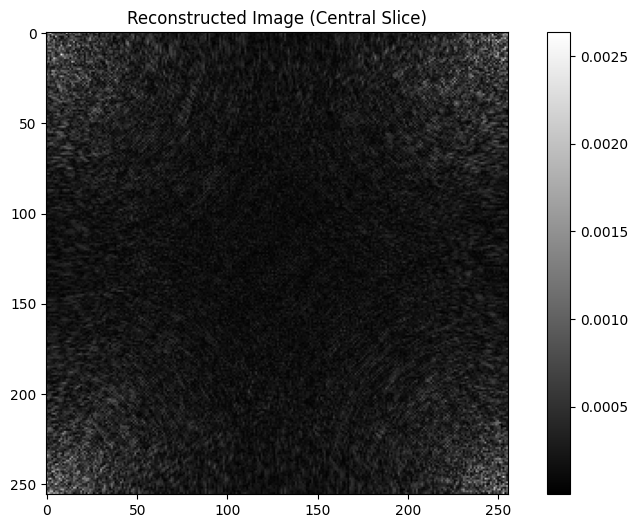

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import pydicom
import glob

# Load DICOM slices into a 3D array
dicom_files = sorted(glob.glob("/content/0020*.dcm"))  # Adjust the pattern to match your files
slices = []

for dicom_file in dicom_files:
    dicom_data = pydicom.dcmread(dicom_file)
    pixel_array = dicom_data.pixel_array.astype(np.float32)
    pixel_array /= pixel_array.max()  # Normalize to [0, 1]
    slices.append(pixel_array)

# Stack slices into a 3D array
volume = np.stack(slices, axis=-1)
image_size = volume.shape  # (kx, ky, kz)

# Generate synthetic tissue property maps
T1_map = 300 + (1200 * volume)  # Scale normalized intensity to T1 values
T2_map = np.random.uniform(50, 100, image_size)  # Example T2 values
M0_map = volume  # Use intensity as equilibrium magnetization

# Simulation parameters
TR = 5  # ms
TE = TR / 2  # Echo Time
alpha = np.radians(30)  # Flip angle in radians
df_map = np.random.uniform(-100, 100, image_size)  # Off-resonance map
num_spokes = 100  # Number of radial spokes
num_slices = image_size[2]  # Number of slices in kz
golden_angle = np.pi * (3 - np.sqrt(5))  # Golden angle for uniform radial coverage

# Calculate E1 and E2
E1_map = np.exp(-TR / T1_map)
E2_map = np.exp(-TR / T2_map)

# Simulate bSSFP signal
S_map = (M0_map * np.sin(alpha)) / (1 - E1_map + E2_map * (1 - np.cos(alpha)))
S_map = S_map.astype(np.complex128)  # Ensure complex type for phase addition
phi_map = 2 * np.pi * df_map * TR / 1000  # Phase in radians
S_map *= np.exp(1j * phi_map)  # Add phase variation

# Initialize radial sampling coordinates
kx, ky, kz = [], [], []

for slice_idx in range(num_slices):  # Loop over slices in kz
    kz_value = (slice_idx - num_slices // 2) / (num_slices // 2)  # Normalize kz
    for spoke_idx in range(num_spokes):  # Loop over radial spokes
        angle = spoke_idx * golden_angle
        for r in np.linspace(0, 1, image_size[0] // 2):  # Radial sampling
            kx.append(r * np.cos(angle))
            ky.append(r * np.sin(angle))
            kz.append(kz_value)

# Convert to arrays
kx = np.array(kx)
ky = np.array(ky)
kz = np.array(kz)

# Cartesian grid for interpolation
kx_cart, ky_cart, kz_cart = np.meshgrid(
    np.linspace(-1, 1, image_size[0]),
    np.linspace(-1, 1, image_size[1]),
    np.linspace(-1, 1, image_size[2])
)
kx_cart = kx_cart.flatten()
ky_cart = ky_cart.flatten()
kz_cart = kz_cart.flatten()

# Ensure equal numbers of radial points and signal values
num_samples = len(kx)
S_map_flat = S_map.flatten()[:num_samples]

# Interpolate radial k-space samples to Cartesian grid
radial_kspace = griddata(
    (kx, ky, kz),
    S_map_flat,  # Use the sampled signal values
    (kx_cart, ky_cart, kz_cart),
    method='linear',
    fill_value=0
).reshape(image_size)

# Add noise to the radial k-space data
noise = np.random.normal(0, 0.01, radial_kspace.shape) + 1j * np.random.normal(0, 0.01, radial_kspace.shape)
radial_kspace_noisy = radial_kspace + noise

# Reconstruct the 3D image using 3D FFT
reconstructed_image = np.abs(np.fft.ifftn(np.fft.ifftshift(radial_kspace_noisy)))

# Display central slice from the reconstructed image
central_slice = reconstructed_image[:, :, image_size[2] // 2]

plt.figure(figsize=(10, 6))
plt.title("Reconstructed Image (Central Slice)")
plt.imshow(central_slice, cmap='gray')
plt.colorbar()
plt.show()
